##まとめ
* 単純なRNNの学習では、勾配爆発、勾配消失が問題になる
* 勾配爆発には勾配クリッピング、勾配消失にはLSTMやGRUなどのゲート付きRNNが有効である
* LSTMにはforgetゲート、outputゲート、inputゲートの3つのゲートがある
* ゲートには専用の重みがあり、sigmoid関数を使って0.0から1.0までの実数を出力する
* 言語モデルの改善にはLSTMレイヤの多層化、Dropout、重み共有などのテクニックが有効である
* RNNの正則化は重要なテーマであり、Dropoutベースのさまざまな手法が提案されている

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL_2'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


##RNNの問題点
* BPTTにおいて、勾配爆発または勾配消失するため、RNNは長期記憶を苦手とする

###勾配消失もしくは勾配爆発の原因
* tanhの微分値は1.0以下のため、tanhノードを通過するたびに勾配が小さくなる
* RNNレイヤの隠れ状態ベクトル$\rm h$に対する重み$\rm W_h$は各時刻Tで共通のものを用いている
* 隠れ状態ベクトル$\rm h$の勾配$d\rm h$には、逆伝搬時にTimeRNNレイヤの各Matmulノードで$d\rm h$→$d\rm hW_h^T$→$d\rm hWh^TW_h^T$→...といったように、重み$\rm W_h$が繰り返し掛けられる（tanhノードは簡単のため省略）
* $\rm W_h$の特異値の最大値が1より大きい場合は、勾配が指数的に増加する可能性が高いと予測でき、1より小さい場合は、勾配が指数的に減少すると判断することができる
* ただし、特異値が1より大きい場合に必ず勾配爆発するわけではない（必要条件であって十分条件ではない）

###勾配爆発への対策
勾配爆発への対策として一般的なものに、勾配クリッピングがある  

$$
\begin{eqnarray}
{\rm if}\ \ \ \ ||{\rm \hat g}||&\geqq& threshold:\\
{\rm \hat g}&=&\dfrac{threshold}{||{\rm \hat g}||}{\rm \hat g}
\end{eqnarray}
$$

${\rm \hat g}$はニューラルネットワークで使われるすべてのパラメータに対する勾配をまとめたもので、$threshold$はしきい値を表す  
勾配のL2ノルム（式中の$||{\rm \hat g}||$）がしきい値を超えた場合、式のように勾配を修正する


In [ ]:
def clip_grads(grads,max_norm):
    total_norm=0
    for grad in grads:
        total_norm+=np.sum(grad**2)
    total_norm=np.sqrt(total_norm)
    rate=max_norm/(total_norm+1e-6)
    if rate<1:  #勾配のL2ノルムがしきい値を超える場合
        for grad in grads:
            grad*=rate

In [ ]:
import numpy as np

dW1=np.random.rand(3,3)*10
dW2=np.random.rand(3,3)*10
grads=[dW1,dW2]
max_norm=5.0
print(grads)
clip_grads(grads,max_norm)
print(grads)

[array([[2.83279327, 9.33274234, 3.117714  ],
       [9.07455786, 1.4481335 , 8.50322409],
       [1.99627325, 6.69092588, 9.1670638 ]]), array([[8.89057285, 3.47141891, 0.37945633],
       [1.24296306, 2.31595782, 0.08849944],
       [5.97809418, 5.81536944, 2.02194025]])]
[array([[0.59526074, 1.96110856, 0.65513173],
       [1.90685572, 0.3042993 , 1.78680017],
       [0.41948105, 1.40597817, 1.92629418]]), array([[1.86819457, 0.72945648, 0.07973595],
       [0.26118641, 0.48665703, 0.01859657],
       [1.25618936, 1.22199568, 0.42487451]])]


##勾配消失とLSTM
* RNNの学習における勾配消失への対応策として、ゲート付きRNNが登場
* ゲート付きRNNの代表格として、LSTM（Long short-term memory）とGRU(Gated Recurrent Unit)がある

###LSTMの実装
$$
\begin{eqnarray}
{\rm f}&=&\sigma({\rm x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)}})\\
{\rm g}&=&\tanh({\rm x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)}})\\
{\rm i}&=&\sigma({\rm x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)}})\\
{\rm o}&=&\sigma({\rm x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)}})\\
\\
{\rm c_t}&=&{\rm f \odot c_{t-1}+g \odot i}\\
{\rm h_t}&=&{\rm o}\odot \tanh(\rm c_t)
\end{eqnarray}
$$

In [ ]:
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]   #f,g,i,o４つ分の重みがひとつの重みにまとめられている　Wx.shape=(D,4H),Wh.shape=(H,4H),b.shape=(4H,)
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None

    def forward(self,x,h_prev,c_prev):
        Wx,Wh,b=self.params
        H=Wh.shape[0]

        A=np.dot(x,Wx)+np.dot(h_prev,Wh)+b  #まとめてAffine変換 A.shapeは(N,4H)
        #対応する要素に分割
        f=A[:,:H]
        g=A[:,H:2*H]
        i=A[:,2*H:3*H]
        o=A[:,3*H:]

        f=sigmoid(f)
        g=np.tanh(g)
        i=sigmoid(i)
        o=sigmoid(o)

        c_next=f*c_prev+g*i #アダマール積(要素ごとの積)
        h_next=o*np.tanh(c_next)    #アダマール積（要素ごとの積）

        self.cache=(x,h_prev,c_prev,i,f,g,o,c_next)

        return h_next,c_next

    def backward(self,dh_next,dc_next):
        Wx,Wh,b=self.params
        x,h_prev,c_prev,i,f,g,o,c_next=self.cache

        tanh_c_next=np.tanh(c_next)
        dtanh_c_next=dh_next*o  #アダマール積の逆伝搬は入力をひっくり返してアダマール積を取る
        ds=dc_next+dtanh_c_next*(1-tanh_c_next**2)  #tanhの逆伝搬は1-y**2
        dc_prev=ds*f    #アダマール積の逆伝搬は入力をひっくり返してアダマール積を取る

        do=dh_next*tanh_c_next
        dA_o=do*o*(1-o) #sigmoidの逆伝搬はy(1-y)
        di=ds*g
        dA_i=di*i*(1-i) #sigmoidの逆伝搬はy(1-y)
        dg=ds*i
        dA_g=dg*(1-g**2)    ##tanhの逆伝搬は1-y**2
        df=ds*c_prev
        dA_f=df*f*(1-f) #sigmoidの逆伝搬はy(1-y)

        dA=np.hstack((dA_f,dA_g,dA_i,dA_o))   #分割した要素を統合する→dA.shapeは(N,4H)
        db=np.sum(dA,axis=0)    #db.shapeは(4H,)
        dWh=np.dot(h_prev.T,dA)    #dWh.shapeは(H,4H)
        dh_prev=np.dot(dA,Wh.T) #dh_prev.shapeは(N,H)
        dWx=np.dot(x.T,dA)  #dWx.shapeは(D,4H)
        dx=np.dot(dA,Wx.T)  #dx.shapeは(N,D)

        self.grads[0][...]=dWx
        self.grads[1][...]=dWh
        self.grads[2][...]=db

        return dx,dh_prev,dc_prev

In [ ]:
import numpy as np
from common.functions import *

N,D,H=2,3,2
x=np.random.randn(N,D).astype('f')
Wx=np.random.randn(D,4*H).astype('f')
Wh=np.random.randn(H,4*H).astype('f')
b=np.zeros((4*H))

print('x\n',x)
print('\nWx\n',Wx)
print('\nWh\n',Wh)
print('\nb\n',b)

h_prev=np.zeros((N,H)).astype('f')
c_prev=np.zeros((N,H)).astype('f')

layer=LSTM(Wx,Wh,b)
h_next,c_next=layer.forward(x,h_prev,c_prev)
print('\nh_next\n',h_next)
print('\nc_next\n',c_next)

dh_next=np.random.randn(N,H).astype('f')
dc_next=np.random.randn(N,H).astype('f')

dx,dh_prev,dc_prev=layer.backward(dh_next,dc_next)
print('\ndx\n',dx)
print('\ndh_prev\n',dh_prev)
print('\ndc_prev\n',dc_prev)
print('\ndWx\n',layer.grads[0])
print('\ndWh\n',layer.grads[1])
print('\ndb\n',layer.grads[2])

x
 [[-1.1399847   1.2299296   1.3698398 ]
 [-0.66625935  0.21324052  0.4937637 ]]

Wx
 [[ 1.469458   -2.0127044  -0.75179774 -0.3144483   1.3375475   1.8691603
   1.6689687   0.3419115 ]
 [ 1.7169586   1.9017862  -0.475566    0.72395754 -0.4364729  -1.6105077
  -0.15475458 -0.8548349 ]
 [ 0.0468122   1.1263891   1.1662451  -1.3115714  -0.9140185  -0.03460084
   0.92339325  0.24915119]]

Wh
 [[-0.02507414  1.2769847  -0.13609092 -0.48923063 -0.48937428  1.2753874
   1.4644818  -0.5688635 ]
 [ 0.18776327 -0.8087184   0.7286179   1.3319004  -2.1791294  -1.8076855
   0.923683    0.3872774 ]]

b
 [0. 0. 0. 0. 0. 0. 0. 0.]

h_next
 [[ 0.01017463 -0.00191651]
 [ 0.0479256  -0.01979113]]

c_next
 [[ 0.03347501 -0.00767339]
 [ 0.14437766 -0.04619587]]

dx
 [[-0.08286672  0.04428254  0.01823515]
 [-0.08772174  0.11836984 -0.18240325]]

dh_prev
 [[ 0.00062887  0.12923778]
 [-0.14313405  0.16258574]]

dc_prev
 [[-0.89682594  1.13158382]
 [ 0.11616708  0.77251356]]

dWx
 [[ 0.          0.         -

###GRUの計算グラフ
$$
{\rm z}=\sigma({\rm x}_t{\rm W_x^{(z)}}+{\rm h}_{t-1}{\rm W_h^{(z)}}+{\rm b^{(z)}})\\
{\rm r}=\sigma({\rm x}_t{\rm W_x^{(r)}}+{\rm h}_{t-1}{\rm W_h^{(r)}}+{\rm b^{(r)}})\\
{\rm \tilde h}=\tanh({\rm x}_t{\rm W_x}+({\rm r}\odot{\rm h}_{t-1}){\rm W_h}+{\rm b})\\
{\rm h}_t=(1-{\rm z})\odot{\rm h}_{t-1}+{\rm z}\odot {\rm \tilde h} 
$$  

* GRUには記憶セルはなく、時間方向への伝搬は隠れ状態のhのみ
* GRUにはresetゲート（r）とupdateゲート（z）の２種類のゲートがある
* resetゲートは過去の隠れ状態をどれだけ無視するのかを決定する
* updateゲートは隠れ状態を更新するゲートであり、LSTMのforgetゲートとinputゲートの２種類の役割を担う
* forgetゲートとして機能するのは$(1-{\rm z})\odot {\rm h}_{t-1}$の箇所
* inputゲートとして機能するのは${\rm z}\odot {\rm \tilde h}$の箇所

###TimeLSTMの実装

In [ ]:
class TimeLSTM:
    def __init__(self,Wx,Wh,b,stateful=False):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers=None
        self.h,self.c=None,None
        self.dh=None
        self.stateful=stateful

    def forward(self,xs):
        Wx,Wh,b=self.params
        N,T,D=xs.shape
        H=Wh.shape[0]
        self.layers=[]

        if not self.stateful or self.h is None:
            self.h=np.zeros((N,H)).astype('f')
        if not self.stateful or self.c is None:
            self.c=np.zeros((N,H)).astype('f')

        hs=np.empty((N,T,H)).astype('f')

        for t in range(T):
            layer=LSTM(Wx,Wh,b)
            self.h,self.c=layer.forward(xs[:,t,:],self.h,self.c)
            hs[:,t,:]=self.h
            self.layers.append(layer)

        return hs

    def backward(self,dhs):
        Wx,Wh,b=self.params
        N,T,H=dhs.shape
        D=Wx.shape[0]

        dxs=np.empty((N,T,D)).astype('f')
        dh,dc=0,0

        grads=[0,0,0]
        for t in reversed(range(T)):
            layer=self.layers[t]
            dx,dh,dc=layer.backward(dhs[:,t,:]+dh,dc)
            dxs[:,t,:]=dx
            for i,grad in enumerate(layer.grads):
                grads[i]+=grad

        for i,grad in enumerate(grads):
            self.grads[i][...]=grad

        self.dh=dh

        return dxs

    def set_state(self,h,c=None):
        self.h,self.c=h,c

    def reset_state(self):
        self.h,self.c=None,None

In [ ]:
import numpy as np
from common.functions import *

N,T,D,H=2,2,3,2
xs=np.random.randn(N,T,D).astype('f')
Wx=np.random.randn(D,4*H).astype('f')
Wh=np.random.randn(H,4*H).astype('f')
b=np.zeros((4*H))

print('xs\n',xs)
print('\nWx\n',Wx)
print('\nWh\n',Wh)
print('\nb\n',b)

layer=TimeLSTM(Wx,Wh,b)
hs=layer.forward(xs)
print('\nhs\n',hs)
print('\nlayers\n',layer.layers)

dhs=np.random.randn(N,T,H).astype('f')
print('\ndhs\n',dhs)
dxs=layer.backward(dhs)
print('\ndxs\n',dxs)
print('\ngrads\n',layer.grads)


xs
 [[[ 0.9830607  -1.7979507   1.0311617 ]
  [ 1.2970983  -0.62310684 -1.6663659 ]]

 [[-1.0099286  -0.9315386  -0.65054363]
  [ 0.8546413  -1.243308   -1.8341453 ]]]

Wx
 [[ 1.2897043   0.0972972  -0.05251349 -0.41560882 -0.5114214   1.6385759
  -1.9638379   0.0400737 ]
 [ 0.9989147  -1.7517143   0.20278661  2.0419343  -0.6201861   1.9143903
   2.2635498  -0.6641958 ]
 [-0.02381596  0.0731368   1.7522241   0.93311226 -0.28582147  0.77122
  -0.77752113  1.1708997 ]]

Wh
 [[-1.0194055   0.93185115 -0.13320437  0.6419536  -1.4029864   0.20498838
   0.45136654  0.4514157 ]
 [ 0.69389683  0.24866487  0.47161108 -0.51158386  0.58092237  2.6803558
  -0.4459653   0.48919445]]

b
 [0. 0. 0. 0. 0. 0. 0. 0.]

hs
 [[[ 0.00052278 -0.23471428]
  [-0.01055047 -0.07285707]]

 [[-0.34720767 -0.00840456]
  [-0.03165304 -0.01756205]]]

layers
 [<__main__.LSTM object at 0x7f14b5fe80b8>, <__main__.LSTM object at 0x7f14ae0e6fd0>]

dhs
 [[[ 0.63100994 -1.0732123 ]
  [ 0.14012782 -0.7788421 ]]

 [[ 1.666410

###LSTMを使った言語モデル
Time Embedding → Time LSTM → Time Affine → Time SoftmaxWithLoss

In [ ]:
class Rnnlm:
    def __init__(self,vocab_size=10000,wordvec_size=100,hidden_size=100):
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn

        #重みの初期化
        embed_W=(rn(V,D)/np.sqrt(V)).astype('f')
        lstm_Wx=(rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b=np.zeros(4*H).astype('f')
        affine_W=(rn(H,V)/np.sqrt(H)).astype('f')
        affine_b=np.zeros(V).astype('f')

        #レイヤの生成
        self.layers=[
                     TimeEmbedding(embed_W),
                     TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True),
                     TimeAffine(affine_W,affine_b)
                     ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.lstm_layer=self.layers[1]

        #パラメータの格納
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,xs):
        for layer in self.layers:
            xs=layer.forward(xs)
        return xs

    def forward(self,xs,ts):
        score=self.predict(xs)
        loss=self.loss_layer.forward(score,ts)
        return loss

    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self,file_name='Rnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)

    def load_params(self,file_name='Rnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params=pickle.load(f)

In [ ]:
import numpy as np
from common.functions import *
from common.util import preprocess
from common.time_layers import *

text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=preprocess(text)

xs=corpus[:-1]
ts=corpus[1:]
corpus_size=len(corpus)
batch_size=2
time_size=2
time_idx=0
data_size=len(xs)

jump=(corpus_size-1)//batch_size
offsets=[i*jump for i in range(batch_size)]
print('offsets\n',offsets)

batch_x=np.empty((batch_size,time_size),dtype='i')
batch_t=np.empty((batch_size,time_size),dtype='i')
for t in range(time_size):
    for i,offset in enumerate(offsets):
        #読み込む位置がコーパスのサイズを超えた場合に最初に戻るように、コーパスサイズで割った余りをインデックスにする
        batch_x[i,t]=xs[(offset+time_idx)%data_size]
        batch_t[i,t]=ts[(offset+time_idx)%data_size]
    time_idx+=1

print('\nbatch_x\n',batch_x)
print('\nbatch_t\n',batch_t)
vocab_size=int(max(corpus)+1)
wordvec_size=2
hidden_size=3

model=Rnnlm(vocab_size,wordvec_size,hidden_size)
print('\nembed_W\n',model.params[0])
print('\nlstm_Wx\n',model.params[1])
print('\nlstm_Wh\n',model.params[2])
print('\nlstm_b\n',model.params[3])
print('\naffine_W\n',model.params[4])
print('\naffine_b\n',model.params[5])

loss=model.forward(batch_x,batch_t)
print('\nloss\n',loss)
dout=1
model.backward(dout)
print('\nembed_dW\n',model.grads[0])
print('\nlstm_dWx\n',model.grads[1])
print('\nlstm_dWh\n',model.grads[2])
print('\nlstm_db\n',model.grads[3])
print('\naffine_dW\n',model.grads[4])
print('\naffine_db\n',model.grads[5])

offsets
 [0, 3]

batch_x
 [[0 1]
 [3 4]]

batch_t
 [[1 2]
 [4 1]]

embed_W
 [[-0.04020209 -0.10200182]
 [-0.71458036  0.13631658]
 [ 0.37632817 -0.35899448]
 [-0.31566727 -0.2843342 ]
 [-0.62049866 -0.0688466 ]
 [-0.45771846  0.3043725 ]
 [-0.2846945  -0.12619233]]

lstm_Wx
 [[-0.42134833  1.183457    0.13706675  0.48772016  0.8901553  -0.19495428
   1.2851942  -0.91762835 -0.90709347  0.08415756 -0.6720333   0.91331446]
 [-0.42906082 -2.014659   -0.14212047 -1.135909    0.33446047  0.60863024
  -0.86991674 -0.20701946  0.03437686 -0.16402395 -0.38889596  0.7338746 ]]

lstm_Wh
 [[ 0.09910761  1.6638727  -0.7167492   0.6232898   0.06729665 -0.77538407
  -0.13910715 -0.6552769  -0.7882195  -1.0854977  -0.61790955  0.37268668]
 [ 0.5167529   1.1045836  -0.18144901 -0.81733626  0.14156389 -0.00469866
  -0.90635985 -0.1626599  -0.4076252   0.3221263  -0.40688327 -0.90814537]
 [ 1.002663    0.35941872 -0.01159666 -0.1839558  -0.77015966 -0.4365899
  -0.66458    -0.35629216  0.49269795 -0.293

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.59
| epoch 1 |  iter 21 / 1327 | time 6[s] | perplexity 2745.54
| epoch 1 |  iter 41 / 1327 | time 12[s] | perplexity 1232.74
| epoch 1 |  iter 61 / 1327 | time 18[s] | perplexity 965.92
| epoch 1 |  iter 81 / 1327 | time 25[s] | perplexity 811.47
| epoch 1 |  iter 101 / 1327 | time 31[s] | perplexity 666.03
| epoch 1 |  iter 121 / 1327 | time 37[s] | perplexity 633.61
| epoch 1 |  iter 141 / 1327 | time 43[s] | perplexity 601.40
| epoch 1 |  iter 161 / 1327 | time 49[s] | perplexity 560.76
| epoch 1 |  iter 181 / 1327 | time 55[s] | perplexity 604.37
| epoch 1 |  iter 201 / 1327 | time 61[s] | perplexity 512.81
| epoch 1 |  iter 221 / 1327 | time 67[s] | perplexity 498.56
| epoch 1 |  iter 241 / 1327 | time 73[s] | perplexity 442.43
| epoch 1 |  iter 261 / 1327 | time 79[s] | perplexity 464.35
| epoch 1 |  iter 281 / 1327 | time 85[s] | perplexity 459.43
| epoch 1 |  iter 301 / 1327 | time 91[s] | perplexity 393.03
| epoch 1 | 

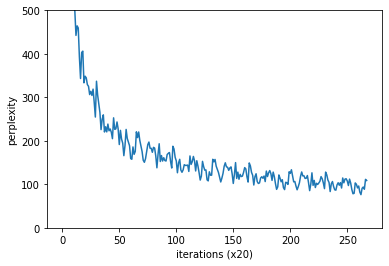

evaluating perplexity ...
116 / 117
test perplexity:  134.81948912246563


In [ ]:
import sys
sys.path.append('..')
from common.np import *
from common.time_layers import *
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
import pickle

batch_size=20
wordvec_size=100
hidden_size=100
time_size=35
lr=20.0
max_epoch=4
max_grad=0.25   #勾配クリッピングのしきい値

#データの読み込み
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_test,_,_=ptb.load_data('test')
vocab_size=len(word_to_id)

xs=corpus[:-1]
ts=corpus[1:]

#モデルの生成
model=Rnnlm(vocab_size,wordvec_size,hidden_size)
optimizer=SGD(lr)
trainer=RnnlmTrainer(model,optimizer)

#勾配クリッピングを適用して学習
trainer.fit(xs,ts,max_epoch,batch_size,time_size,max_grad,eval_interval=20)
trainer.plot(ylim=(0,500))

#テストデータで評価
model.reset_state()
ppl_test=eval_perplexity(model,corpus_test,batch_size,time_size)
print('test perplexity: ',ppl_test)

#パラメータの保存
model.save_params('/content/drive/My Drive/Colab Notebooks/zero_DL_2/ch06/Rnnlm.pkl')

##RNNLMのさらなる改良

###LSTMレイヤの多層化
* １つ目のLSTMレイヤの隠れ状態が二つ目のLSTMレイヤの入力になる
* どれだけ層を重ねるかはハイパーパラメータであり、取り組む問題の複雑さや用意された学習データの数によって適宜決める必要がある
* PTBデータセットの言語モデルの場合は、LSTMの層数は2から4程度が良い結果が得られる

###Dropoutによる過学習の抑制
* 層を増やして表現力が豊かになると、過学習を起こしやすくなる
* RNNは通常のフィードフォワードネットワークに比べて簡単に過学習を起こす
* 過学習を抑制するには、「訓練データを増やす」ことと、「モデルの複雑さを減らす」ことが有効
* モデルの複雑さにペナルティを与える正則化（重みが大きくなりすぎることにペナルティを与える）も有効
* Dropoutは訓練時にいくつかのニューロン（例えば50%など）をランダムに無視して学習を行うため、一種の正則化と言える
* RNNを使ったモデルにおいて、通常のDropoutレイヤを時系列方向に挿入するのは良くない  
    （時系列方向にDropoutレイヤを挿入してしまうと、学習時には時間が進むにつれて情報が失われる他、時間が進むのに比例してDropoutによるノイズが蓄積する）
* Dropoutレイヤを深さ方向に挿入すれば、時間方向にどれだけ進んでも情報は失われない
* 「変分Dropout(variational dropout)」はRNNの時間方向の正則化を目的として提案された方法で、時間方向への適用に成功している

In [ ]:
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio    #0から1までの乱数を一様分布から生成し、ドロップアウト率と比較した結果をブール値で格納
            #ドロップアウト率だけ出力が小さくなるため、スケールをもとに戻す
            #（dropout_ratio=1/5の場合、1/5のニューロンが無視されるから出力は4/5になる→5/4を掛けて出力を1に戻す）
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale  #flgのうちTrueの箇所はTrue(=1)*scale=scale,Falseの箇所はFalse(=0)*scale=0としたものをmaskとする

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask #順伝搬時に無視したニューロンでは逆伝搬もストップする(伝搬する値を0にする)

###重み共有（weight tying）
* Embeddingレイヤの重みとAffineレイヤの重みを共有する
* Embeddingレイヤの重みの形状は(V,D)であり、Affineレイヤの重みの形状は(D,V)であるため、重み共有ではEmbeddingレイヤの重みの転置をAffineレイヤの重みに設定する

###より良いRNNLMの実装

In [ ]:
import sys
sys.path.append('..')
import os
import pickle
from common.util import to_gpu, to_cpu

class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


In [ ]:
class BetterRnnlm(BaseModel):
    def __init__(self,vocab_size=10000,wordvec_size=650,hidden_size=650,dropout_ratio=0.5):
        #重みの初期化
        V,D,H=vocab_size,wordvec_size,hidden_size
        rn=np.random.randn

        embed_W=(rn(V,D)/100).astype('f')
        lstm1_Wx=(rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm1_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm1_b=np.zeros(4*H).astype('f')
        lstm2_Wx=(rn(H,4*H)/np.sqrt(D)).astype('f') #２つ目のLSTMレイヤへの入力は、１つ目のLSTMレイヤの出力hs(N,T,H)のため、重みWxの形状は(H,4*H)
        lstm2_Wh=(rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm2_b=np.zeros(4*H).astype('f')
        affine_b=np.zeros(V).astype('f')

        #レイヤの生成
        self.layers=[
                     TimeEmbedding(embed_W),
                     TimeDropout(dropout_ratio),
                     TimeLSTM(lstm1_Wx,lstm1_Wh,lstm1_b,stateful=True),
                     TimeDropout(dropout_ratio),
                     TimeLSTM(lstm2_Wx,lstm2_Wh,lstm2_b,stateful=True),
                     TimeDropout(dropout_ratio),
                     TimeAffine(embed_W.T,affine_b)   #Embeddingレイヤと重みを共有
        ]
        self.loss_layer=TimeSoftmaxWithLoss()
        self.lstm_layers=[self.layers[2],self.layers[4]]
        self.drop_layers=[self.layers[1],self.layers[3],self.layers[5]]

        #パラメータの格納
        self.params,self.grads=[],[]
        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,xs,train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg=train_flg
        for layer in self.layers:
            xs=layer.forward(xs)
        return xs

    def forward(self,xs,ts,train_flg=True):
        score=self.predict(xs,train_flg)
        loss=self.loss_layer.forward(score,ts)
        return loss

    def backward(self,dout=1):
        dout=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout=layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('..')
from common import config
config.GPU=True
from common.np import *
from dataset import ptb
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from common.time_layers import *

#ハイパーパラメータの設定
batch_size=20
wordvec_size=650
hidden_size=650
time_size=35
lr=20.0
max_epoch=40
max_grad=0.25
dropout_ratio=0.5

#データの読み込み
corpus,word_to_id,id_to_word=ptb.load_data('train')
corpus_val,_,_=ptb.load_data('val')
corpus_test,_,_=ptb.load_data('test')
xs=corpus[:-1]
ts=corpus[1:]
vocab_size=len(word_to_id)

model=BetterRnnlm(vocab_size,wordvec_size,hidden_size,dropout_ratio)
optimizer=SGD(lr)
trainer=RnnlmTrainer(model,optimizer)

best_ppl=float('inf')   #パープレキシティを無限（十分に大きな数）で初期化
for epoch in range(max_epoch):
    #1epochごとにパープレキシティを評価し学習率を変えるため、fit関数のmax_epochは1とする
    trainer.fit(xs,ts,max_epoch=1,batch_size=batch_size,time_size=time_size,max_grad=max_grad)

    model.reset_state()
    ppl=eval_perplexity(model,corpus_val)
    print('valid perplexity: ',ppl)

    if best_ppl>ppl:    #パープレキシティが良くなった（小さくなった）場合
        best_ppl=ppl    #best_pplを現在のpplで更新
        model.save_params('/content/drive/My Drive/Colab Notebooks/zero_DL_2/ch06/BetterRnnlm.pkl')
    else:   #パープレキシティが悪くなった（大きくなった）場合
        lr/=4.0 #学習率を小さくする
        optimizer.lr=lr #optimizerの学習率を更新

    model.reset_state()
    print('-'*50)

ストリーミング出力は最後の 5000 行に切り捨てられました。
| epoch 10 |  iter 821 / 1327 | time 149[s] | perplexity 79.63
| epoch 10 |  iter 841 / 1327 | time 153[s] | perplexity 77.27
| epoch 10 |  iter 861 / 1327 | time 156[s] | perplexity 78.55
| epoch 10 |  iter 881 / 1327 | time 160[s] | perplexity 71.71
| epoch 10 |  iter 901 / 1327 | time 164[s] | perplexity 91.49
| epoch 10 |  iter 921 / 1327 | time 167[s] | perplexity 79.62
| epoch 10 |  iter 941 / 1327 | time 171[s] | perplexity 84.99
| epoch 10 |  iter 961 / 1327 | time 174[s] | perplexity 92.57
| epoch 10 |  iter 981 / 1327 | time 178[s] | perplexity 87.47
| epoch 10 |  iter 1001 / 1327 | time 182[s] | perplexity 75.93
| epoch 10 |  iter 1021 / 1327 | time 185[s] | perplexity 89.48
| epoch 10 |  iter 1041 / 1327 | time 189[s] | perplexity 75.67
| epoch 10 |  iter 1061 / 1327 | time 193[s] | perplexity 72.22
| epoch 10 |  iter 1081 / 1327 | time 196[s] | perplexity 60.35
| epoch 10 |  iter 1101 / 1327 | time 200[s] | perplexity 61.00
| epoch 10 |  ite